In [18]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from collections import defaultdict
import os
import PIL
from scipy.io import wavfile
import torchaudio
from IPython.display import Audio, display

In [19]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
!mkdir .kaggle
!mv kaggle.json .kaggle/
!mv .kaggle ~/

In [21]:
!kaggle datasets download lantian773030/pokemonclassification
!unzip pokemonclassification.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: PokemonData/Golbat/78bb8cd2828f40158fc0dcd4c0366a57.jpg  
  inflating: PokemonData/Golbat/7b7a064d3a1b4c53a9be936d4e4e3bab.jpg  
  inflating: PokemonData/Golbat/7d07fd6776fb40e9986a1a0f62233325.jpg  
  inflating: PokemonData/Golbat/815b279060b94e12a6b35d434a5250c2.jpg  
  inflating: PokemonData/Golbat/818014085ff04885b31eb5e8737012f2.jpg  
  inflating: PokemonData/Golbat/87529331a47b4a5cb5d10a6b3ea46d84.jpg  
  inflating: PokemonData/Golbat/914fab74d32e49a98940d5ba7f674fa6.jpg  
  inflating: PokemonData/Golbat/949a05bd0ad44be993e5fd89a8f582df.jpg  
  inflating: PokemonData/Golbat/9a4c793b9b0042a99ebd540897f9f898.jpg  
  inflating: PokemonData/Golbat/a35b4e8e603c485cb197520af30e1208.jpg  
  inflating: PokemonData/Golbat/a45a14a67a7348bba57c06467bb73cde.jpg  
  inflating: PokemonData/Golbat/acc2b44eada74a25a64c041b2e80c453.jpg  
  inflating: PokemonData/Golbat/af30483e382240d38890dec39e083b08.jpg  
  inflating: Pok

Como se explico en el anterior notebook, no se toma en cuenta la data augementation pues nos genera un overfiting por lo que se decidio no colocarlo en este cuaderno

In [22]:
# Esto no se necesita modificar. Son las funciones para entrenar el modelo.
# OPTIONAL:
# Si se desea se puede modificar para por ejemplo almacenar el accuracy y el loss de cada epoca para poder plotearlo luego
acc_train = []
def evaluate(model, loader, crit):
  model.eval()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in loader:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100* corrects / total
  avg_loss /= len(loader)  
  return avg_loss, acc

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100 * corrects / total
  avg_loss /= len(train_loader)
  return avg_loss, acc

def train(model, train_loader, test_loader, crit, optim, epochs = 20):
  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader,crit, optim)
    test_loss, test_acc = evaluate(model, test_loader, crit)
    acc_train.append({train_acc,test_acc})
    print(f"epoch: {epoch}, train loss: {train_loss}, train acc: {train_acc}%, test loss: {test_loss}, test acc: {test_acc}%")

Transformamos nuestra imagenes a un size de 244x 244 y despues lo convertimos a un vector.

In [23]:
from torchvision.transforms.transforms import RandomGrayscale
# Esto tampoco se necesita modificar.
# OPTIONAL:
# Se puede aumentar más transformaciones (data augmentation) o cambiar el tamaño del resizing.
img_transform = torchvision.transforms.Compose([
  #torchvision.transforms.RandomHorizontalFlip(0.6),
  #torchvision.transforms.RandomVerticalFlip(0.6),
  #torchvision.transforms.RandomRotation(degrees=(0,180)),
  #torchvision.transforms.RandomPerspective(distortion_scale=0.6,p=0.6),
  #torchvision.transforms.RandomGrayscale(0.6),
  torchvision.transforms.Resize((224,224)),
  torchvision.transforms.ToTensor()
])

In [24]:
# TODO: Modificar el path en donde se encuentrar sus imagenes de training y testing
train_ds = torchvision.datasets.ImageFolder("./PokemonData/",transform=img_transform)
test_ds = torchvision.datasets.ImageFolder("./PokemonData/",transform=img_transform)

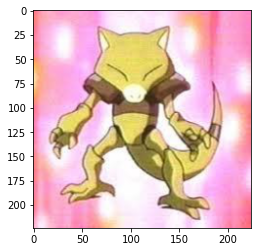

In [25]:
# Esto es solo para poder ver un ejemplo de las imagenes que se estan usando
plt.imshow(train_ds[0][0].numpy().transpose(1,2,0))

In [26]:
# Esto no se necesita modificar al menos que se quiera utilizar un batch size diferente
# OPTIONAL:
# Cambiar la opción de shuffle a False y observar que pasa con los input y targets que nos brinda el dataloader, que diferencias hay?
# Observar que pasa con el accuracy cuando no se realiza el shuffling y explicar porque.

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=128,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=128,shuffle=True)

In [ ]:
Definimos el modelos una capa convolucional, seguida de un batch Norm una funcion de activación y un max pool teminando con una capa Lineal que acepta 1024 patronos y nos dara como resulta 150 clases 

In [27]:
# TODO: Definir el modelo
model = nn.Sequential(
  # DEFINIR LOS LAYERS
  nn.Conv2d(3,16,7,bias=False),
  nn.BatchNorm2d(16),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(16,32,3,bias=False),
  nn.BatchNorm2d(32),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(32,32,3,bias=False),
  nn.BatchNorm2d(32),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(32,64,3,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(64,64,3,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Flatten(),
  nn.Linear(1024,150)
).to(dev)

In [28]:
# Esto tampoco se necesita modificar
# OPTIONAL:
# Se puede aumentar o disminuir el learning rate para observar como es la evolucion de los accuracy y loss.
#!CUDA_LAUNCH_BLOCKING=1
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.1)
train(model,train_dl, test_dl, crit, optim, epochs=10)

epoch: 0, train loss: 3.9108990828196206, train acc: 12.287390029325513%, test loss: 8.641218379691795, test acc: 4.516129032258065%
epoch: 1, train loss: 2.5303075666780823, train acc: 37.18475073313783%, test loss: 3.0911949475606284, test acc: 26.671554252199414%
epoch: 2, train loss: 1.806648247771793, train acc: 54.83870967741935%, test loss: 2.8694866365856595, test acc: 31.80351906158358%
epoch: 3, train loss: 1.380031528296294, train acc: 64.57478005865103%, test loss: 2.2393853774777166, test acc: 42.683284457478%
epoch: 4, train loss: 1.105198421963939, train acc: 71.3782991202346%, test loss: 3.166526851830659, test acc: 34.34017595307918%
epoch: 5, train loss: 0.8865929411517249, train acc: 78.32844574780059%, test loss: 1.795173872400213, test acc: 53.841642228739005%
epoch: 6, train loss: 0.7017209745115705, train acc: 82.77126099706744%, test loss: 0.756817446814643, test acc: 79.12023460410558%
epoch: 7, train loss: 0.5678739487021057, train acc: 86.3782991202346%, test

In [59]:
import os
pokemones = os.listdir('./PokemonData')
pokemones = sorted(pokemones)  


4


'Arbok'

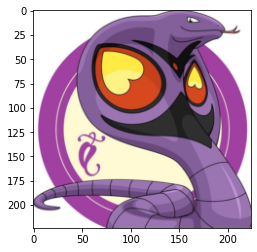

In [30]:
model.eval()
# idx = 10
idx = 1000
x, y = test_ds[140]
x_numpy = x.numpy().transpose(1,2,0)
N, H, W = x.shape
x = x.reshape(1,N,H,W)
pred = torch.argmax(model(x.to(dev)).cpu()).item()

plt.imshow(x_numpy)

pokemones[pred]

Evaluamos las mismas 8 iamgenes del modelo anterior para asi poder comparar.

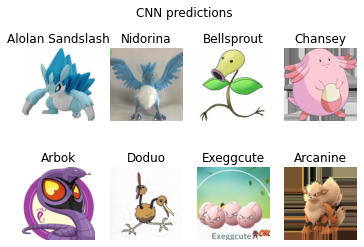

In [62]:
import math
def imagenEval(id):

  model.eval()
  x, y = test_ds[id]
  x_numpy = x.numpy().transpose(1,2,0)
  N, H, W = x.shape
  x = x.reshape(1,N,H,W)
  pred = torch.argmax(model(x.to(dev)).cpu()).item()
  return x_numpy, pred

ids =[120,240,300,500,140,1000,1400,200]
fig, (r) = plt.subplots(2,4) 
fig.suptitle('CNN predictions')
for i in range(len(ids)):
  ax = r[math.floor(i/4)][i%4]
  im,pred = imagenEval(ids[i])
  ax.imshow(im)
  ax.set_title(pokemones[pred])
  ax.axis('off')
plt.show()



In [32]:
torch.save(model.state_dict(),"proyectoRoyer.ckpt")

Vemos que el acc en el entrenamiento pueede alcanzar acc en el test por lo cual es un modelo aceptable

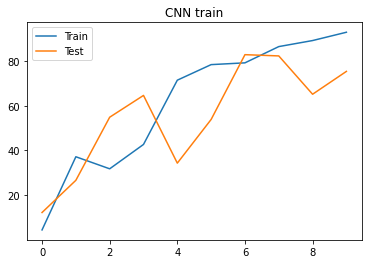

In [48]:
array_train=[]
array_test= []
for i in acc_train:
  test,train = list(i)
  array_train.append(train)
  array_test.append(test)
abcisa = np.arange(10)
plt.plot(abcisa,array_train,label="Train")
plt.plot(abcisa,array_test,label="Test")
plt.legend(loc = "upper left")
plt.title("CNN train")
plt.show()

[0 1 2 3 4 5 6 7 8 9]
